In [1]:
from qiskit import QuantumCircuit, transpile
# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeManila, FakeToronto
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import sklearn.preprocessing as skp
from scipy.signal import savgol_filter
import os
import sys
from datetime import date
import pathlib
import inspect
import time
import math

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('..')) # qrc_surrogate
sys.path.append(module_path)


# Transfering qubit state info in the style of weak measurements
at which values 
- complete copying of state qubit 0 to qubit 1 (qubit 0 |1> -> qubit 1 |>): 
    - pi/2 (counterrotated)
    - 3/2 pi (move qubit information completely)
- no information moving (qubit 1 50/50): 
    - 0, pi

In [2]:
shots = 10000
sim = AerSimulator()

In [3]:
def add_weak_measurement(qcm, a=1, wmtarget=0, th=-0.25):
    qcm.h(a)
    qcm.ry(th, a)
    qcm.cx(wmtarget, a)
    return qcm

def get_counts(qct):
    qct = transpile(qct, sim)
    job = sim.run(qct, shots=shots)
    result = job.result()
    counts = result.get_counts()
    return counts

## Small test

In [4]:
# parameters
startangle = np.pi * 1.25
weak_measurement_angle = np.pi * 1.25
a = 1
wmtarget = 0
cbit = 0

# run
qc = QuantumCircuit(2, 1)
qc.rx(startangle, wmtarget)
qc.measure(wmtarget, cbit)

cnts = get_counts(qc)
mean = np.sum([int(k) * v for k, v in cnts.items()]) / shots

print('Measuring original qubit')
print(cnts)
print(mean)

qc.draw()

Measuring original qubit
{'0': 1436, '1': 8564}
0.8564


┌──────────┐┌─┐
q_0: ┤ Rx(5π/4) ├┤M├
     └──────────┘└╥┘
q_1: ─────────────╫─
                  ║ 
c: 1/═════════════╩═
                  0

In [5]:
# run
qc = QuantumCircuit(2, 1)
# qc = add_weak_measurement(qc)
qc = add_weak_measurement(qc, th=weak_measurement_angle)
qc.measure(wmtarget, cbit)

cnts = get_counts(qc)
mean = np.sum([int(k) * v for k, v in cnts.items()]) / shots

print('- Measuring original qubit')
print('Bitstrings:', cnts)
print('Mean:', mean)

qc.draw()

- Measuring original qubit
Bitstrings: {'0': 10000}
Mean: 0.0


┌─┐
q_0: ───────────────────■──┤M├
     ┌───┐┌──────────┐┌─┴─┐└╥┘
q_1: ┤ H ├┤ Ry(5π/4) ├┤ X ├─╫─
     └───┘└──────────┘└───┘ ║ 
c: 1/═══════════════════════╩═
                            0

In [6]:
# run
qc = QuantumCircuit(2, 1)
qc.rx(startangle, wmtarget)
# qc = add_weak_measurement(qc)
qc = add_weak_measurement(qc, a=a, wmtarget=wmtarget, th=weak_measurement_angle)
qc.measure(a, cbit)

cnts = get_counts(qc)
mean = np.sum([int(k) * v for k, v in cnts.items()]) / shots

print('Measuring ancilla qubit')
print(cnts)
print(mean)

qc.draw()

Measuring ancilla qubit
{'0': 2522, '1': 7478}
0.7478


┌──────────┐                    
q_0: ┤ Rx(5π/4) ├──────────────■─────
     └──┬───┬───┘┌──────────┐┌─┴─┐┌─┐
q_1: ───┤ H ├────┤ Ry(5π/4) ├┤ X ├┤M├
        └───┘    └──────────┘└───┘└╥┘
c: 1/══════════════════════════════╩═
                                   0

In [7]:
# run
qc = QuantumCircuit(2, 1)
qc.rx(startangle, wmtarget)
# qc.x(wmtarget)
# qc = add_weak_measurement(qc)
qc = add_weak_measurement(qc, a=a, wmtarget=wmtarget, th=weak_measurement_angle)
qc.reset(wmtarget)
qc.barrier()
qc.measure(a, cbit)

cnts = get_counts(qc)
mean = np.sum([int(k) * v for k, v in cnts.items()]) / shots

print('- Measuring ancilla qubit after resetting original qubit')
print(cnts)
print(mean)

qc.draw()

- Measuring ancilla qubit after resetting original qubit
{'0': 2485, '1': 7515}
0.7515


┌──────────┐                       ░    
q_0: ┤ Rx(5π/4) ├──────────────■───|0>──░────
     └──┬───┬───┘┌──────────┐┌─┴─┐      ░ ┌─┐
q_1: ───┤ H ├────┤ Ry(5π/4) ├┤ X ├──────░─┤M├
        └───┘    └──────────┘└───┘      ░ └╥┘
c: 1/══════════════════════════════════════╩═
                                           0

In [8]:
# run
qc = QuantumCircuit(2, 2)
qc.rx(startangle, wmtarget)
# qc.x(wmtarget)
# qc = add_weak_measurement(qc)
qc = add_weak_measurement(qc, a=a, wmtarget=wmtarget, th=weak_measurement_angle)
qc.measure(wmtarget, 0)
qc.barrier()
qc.measure(a, 1)

cnts = get_counts(qc)

print('- Measuring ancilla qubit ater measuring original qubit')
print(cnts)

# mean = np.sum([int(k) * v for k, v in cnts.items()]) / shots
means = np.flip(
            np.sum(
                np.array([
                    [
                        int(bit) * cnts[bitstring] 
                        for bit in bitstring
                    ] 
                    for bitstring in cnts.keys()
                ]
            ), axis=0)
        ) / shots
print('means', means)

qc.draw()

- Measuring ancilla qubit ater measuring original qubit
{'01': 1278, '10': 235, '00': 1216, '11': 7271}
means [0.8549 0.7506]


┌──────────┐                 ┌─┐ ░    
q_0: ┤ Rx(5π/4) ├──────────────■──┤M├─░────
     └──┬───┬───┘┌──────────┐┌─┴─┐└╥┘ ░ ┌─┐
q_1: ───┤ H ├────┤ Ry(5π/4) ├┤ X ├─╫──░─┤M├
        └───┘    └──────────┘└───┘ ║  ░ └╥┘
c: 2/══════════════════════════════╩═════╩═
                                   0     1

# Systematic sweep
how much information transfer is there given the ry (weak measurement) angle?
- i.e. how uniquely do rx (input) values map to expectation values?
- weak measurement over rx is flat -> no information

In [9]:
# plot information movement
def measurement_over_weak_measurement_angle(startrx=True):
    a = 1
    wmtarget = 0
    cbit = 0
    wm_angle = np.linspace(0, 2, 100)
    startangles = np.linspace(0, 1, 9)
    ys = []
    for startangle in startangles:
        means = []
        for th in wm_angle:
            qc = QuantumCircuit(2, 1)
            if startrx:
                qc.rx(startangle*np.pi, wmtarget)
            else:
                qc.ry(startangle*np.pi, wmtarget)
            # qc = add_weak_measurement(qc)
            qc = add_weak_measurement(qc, th=th*np.pi, a=a, wmtarget=wmtarget)

            qc.measure(a, cbit)
            cnts = get_counts(qc)

            # mean = cnts['1'] / shots # problem if no 1s
            mean = np.sum([int(k) * v for k, v in cnts.items()]) / shots
            x_expected = 0.5
            # means.append(abs(x_expected - mean) / x_expected)
            means.append(mean)
        ys.append(means)
    xs = [wm_angle for _ in startangles]
    return xs, ys, startangles

def measurement_over_qubit_state(startx=True):
    a = 1
    wmtarget = 0
    cbit = 0
    wm_angle = np.linspace(0, .5, 9)
    rxstarts = np.linspace(0, 1, 100)
    ys = []
    for th in wm_angle:
        means = []
        for startangle in rxstarts:
            qc = QuantumCircuit(2, 1)
            if startx:
                qc.rx(startangle*np.pi, wmtarget)
            else:
                qc.ry(startangle*np.pi, wmtarget)
            # qc = add_weak_measurement(qc)
            qc = add_weak_measurement(qc, th=th*np.pi, a=a, wmtarget=wmtarget)

            qc.measure(a, cbit)
            cnts = get_counts(qc)

            # mean = cnts['1'] / shots # problem if no 1s
            mean = np.sum([int(k) * v for k, v in cnts.items()]) / shots
            x_expected = 0.5
            # means.append(abs(x_expected - mean) / x_expected)
            means.append(mean)
        ys.append(means)
    xs = [rxstarts for _ in wm_angle]
    return xs, ys, wm_angle

def separateplotting(xs, ys, spvalues):
    for i in range(len(spvalues)):
        plt.figure()
        plt.plot(xs[i], ys[i])
        plt.ylim(-0.1, 1.1)
        plt.title(f'rx(theta={spvalues[i]:.2f}Pi)')
        plt.xlabel('theta (ry weak measurement) [Pi]')
        plt.ylabel('Mean (Weak measurement)')
        plt.show()

def subplotting(xs, ys, spvalues, xlabel='', ylabel='', title=''):
    """List of list of values (subplots, steps)"""
    cols = 3
    rows = math.ceil(len(xs) / cols)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 12))

    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    fig.suptitle(title, fontsize=18, y=0.95)

    i = 0 # index
    for r in range(rows):
        for c in range(cols):
            if i == len(xs):
                break
            ax = axes[r][c]
            ax.plot(xs[i], ys[i])

            # formatting
            ax.set_title(f'{spvalues[i]:.2f} Pi')
            # ax.get_legend().remove()
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.set_ylim(-0.1, 1.1)

            i += 1
    
    plt.show()

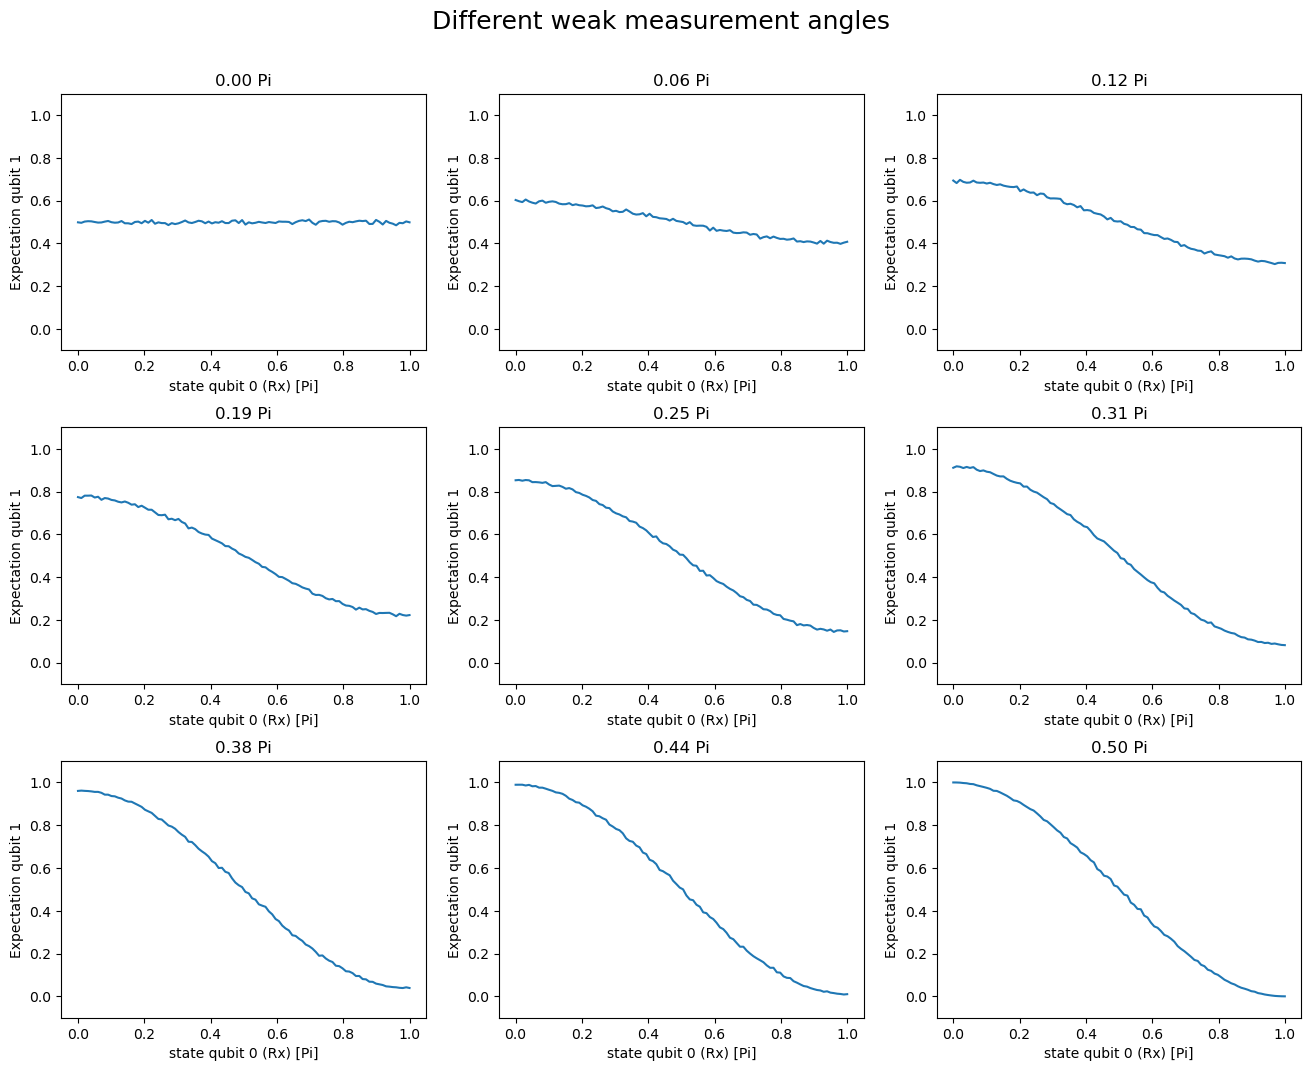

In [10]:

# subplotting(*measurement_over_weak_measurement_angle(), ylabel='Expectation qubit 1', xlabel='Ry weak measurement [Pi]', title="Different states of a")

subplotting(*measurement_over_qubit_state(), ylabel='Expectation qubit 1', xlabel='state qubit 0 (Rx) [Pi]', title="Different weak measurement angles")

# fig.savefig(savepath, bbox_inches='tight', format='svg')

# separateplotting(xs, ys, spvalues)

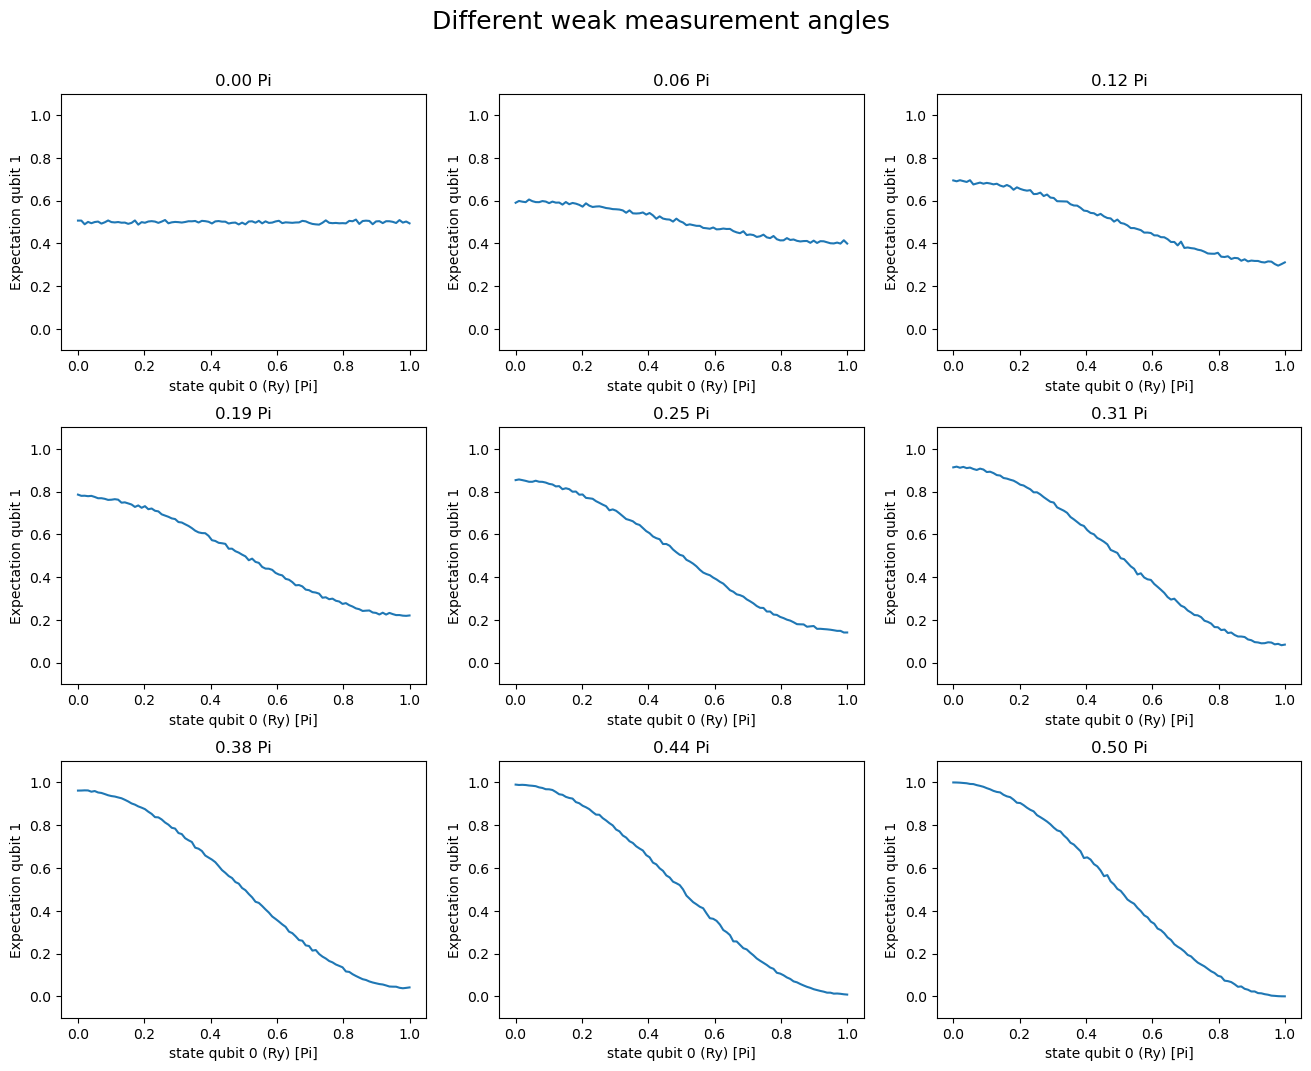

In [11]:
subplotting(*measurement_over_qubit_state(startx=False), ylabel='Expectation qubit 1', xlabel='state qubit 0 (Ry) [Pi]', title="Different weak measurement angles")